In [1]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
import re
import datetime

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from sklearn import linear_model
from cycler import cycler
from celluloid import Camera

from IPython.display import HTML



import warnings

import numpy as np
import pandas as pd
import copy
import random

from tslib.src import tsUtils
from tslib.src.synthcontrol.syntheticControl import RobustSyntheticControl
from tslib.tests import testdata

warnings.filterwarnings(action='once')


In [2]:
# function to create filtered dataframe and align timeseries to that start of the spread

def create_filtered_data(df, threshold):
    pattern = re.compile('(Unknown|Unassigned)')
    newdf = pd.DataFrame()
    for location in df.columns:
        if(pattern.search(location)):
            continue
        highnumber = df[df[location].gt(threshold)]
        if(len(highnumber)>0):
            newdf = pd.concat([newdf, pd.DataFrame(columns=[location], data=df.loc[highnumber.index[0]:,location].values)], axis=1)
    return newdf

# function to build and plot synthetic control baswed projections. The first threshold is which regions to use in the donor pool 
# - the ones that have had the timeseries for threshold days and above. The low_thresh is to do predictions for regions that
# have had the spread for at least low_thresh days but below threshold days


def synth_control_predictions2(df, threshold, low_thresh,  title_text, singVals=2, 
                               savePlots=False, ylimit=[], logy=False, exclude=[], 
                               svdSpectrum=False, do_only=[], showstates=4, animation=[], donorPool=[]):
    sizes = df.apply(pd.Series.last_valid_index)
    sizes = sizes.fillna(0).astype(int)
    
    if (donorPool):
        otherStates=donorPool
    else:
        otherStates = list(sizes[sizes>threshold].index)
    if(exclude):
        for member in exclude:
            if(member in otherStates):
                otherStates.remove(member)
    if(do_only):
        for member in exclude:
            if(member in otherStates):
                otherStates.remove(member)
        for member in do_only:
            if(member in otherStates):
                otherStates.remove(member)
            
    
    showstates = np.minimum(showstates,len(otherStates))
    otherStatesNames = otherStates
    otherStatesNames = [w.replace('-None', '') for w in otherStates]
    for state in otherStatesNames:
        state.replace("-None","")
    print(otherStates)
    if(do_only):
        prediction_states = list(sizes[sizes.index.isin(do_only)].index)
        print(prediction_states)
    else:
        prediction_states = list(sizes[(sizes>low_thresh) & (sizes<=threshold)].index)
    
    
    for state in prediction_states:
        trainDF=df.iloc[:low_thresh,:]
        print(trainDF.shape)
        testDF=df.iloc[low_thresh+1:threshold,:]
        rscModel = RobustSyntheticControl(state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
        rscModel.fit(trainDF)
        denoisedDF = rscModel.model.denoisedDF()
        predictions = []
    
        predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
        predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
        x_actual=range(sizes[state])
        actual = df.iloc[:sizes[state],:][state]
        
        #plt.plot(x_actual,actual,label='Actuals', color='k')
        if (svdSpectrum):
            all_rows = list.copy(otherStates)
            all_rows.append(state)
            (U, s, Vh) = np.linalg.svd((trainDF[all_rows]) - np.mean(trainDF[all_rows]))
            s2 = np.power(s, 2)
            plt.figure(figsize=(8,6))

            #plt.yscale('log')
            plt.plot(s2)
            plt.grid()
            plt.xlabel("Ordered Singular Values") 
            plt.ylabel("Energy")
            plt.title("Singular Value Spectrum")
            plt.show()
        x_predictions=range(low_thresh,low_thresh+len(predictions))
        model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
        #print(list(zip(otherStatesNames, rscModel.model.weights/np.max(rscModel.model.weights))))
        
        if not animation:
            plt.figure(figsize=(16,6))
        
        
        
        plt.subplot(121)
        ind = np.argpartition(rscModel.model.weights, -showstates)[-showstates:]
        topstates = [otherStates[i] for i in ind]
        #plt.barh(topstates, rscModel.model.weights[ind]/np.max(rscModel.model.weights), color=list('rgbkymc'))
        plt.barh(otherStates, rscModel.model.weights/np.max(rscModel.model.weights), color=list('rgbkymc'))
        plt.title("Normalized weights for "+str(state).replace("-None","").split(" minus", 1)[0])

        #plt.show()
        plt.subplot(122)
        
        if(ylimit):
            plt.ylim(ylimit)
        if(logy):
            plt.yscale('log')
        
        plt.plot(x_actual,actual,label='Actuals', color='k', linestyle='-')
        plt.plot(x_predictions,predictions,label='Predictions', color='r', linestyle='--')
        plt.plot(range(len(model_fit)), model_fit, label = 'Fitted model', color='g', linestyle=':')
        plt.axvline(x=low_thresh-1, color='k', linestyle='--', linewidth=4)
        plt.title(title_text+" for "+str(state).replace("-None","").split(" minus", 1)[0]) 
        
        plt.xlabel("Days Since 10 cases")
        plt.ylabel("Cases")
        plt.legend(['Actuals', 'Predictions', 'Fitted Model'])
        plt.grid()
        if (savePlots):
            plt.savefig("../Figures/COVID/"+state+".png")
        
        
        if(animation):
            animation.snap()

        else:
            plt.show()
    return(topstates)
        
        
        
#global settings for graphs        
cc = (cycler(color=list('rgbcmyk')) *
      cycler(linestyle=['-', '--', '-.',':']))
plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=cc)

In [3]:
usstates = pd.read_csv("../COVID/covid-19-data/us-states.csv")
uscounties = pd.read_csv("../COVID/covid-19-data/us-counties.csv")
uscounties['county_state']=uscounties['county']+'-'+uscounties['state']
uscases = usstates.pivot(index='date', columns='state', values='cases')
usdeaths= usstates.pivot(index='date', columns='state', values='deaths')
uscounties_deaths = uscounties.pivot_table(index='date', columns='county_state', values='deaths')
uscounties_cases = uscounties.pivot_table(index='date', columns='county_state', values='cases')
global_covid = pd.read_csv("../COVID/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
us_covid_jhu = pd.read_csv("../COVID/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")
global_covid_cases = pd.read_csv("../COVID/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
global_covid['Province-Country']=global_covid['Country/Region']+'-'+global_covid['Province/State'].fillna("None")
global_covid['Province-Country'] = global_covid['Province-Country'].str.replace("-None","")
global_covid=global_covid.set_index('Province-Country')
global_deaths = global_covid.loc[:,'1/22/20':].T

global_covid_cases['Province-Country']=global_covid_cases['Country/Region']+'-'+global_covid_cases['Province/State'].fillna("")
global_covid_cases=global_covid_cases.set_index('Province-Country')
global_cases = global_covid_cases.loc[:,'1/22/20':].T

#us_covid_jhu['Province-Country']=global_covid['Country/Region']+'-'+global_covid['Province/State'].fillna("None")
us_covid_jhu=us_covid_jhu.set_index('Combined_Key')
us_covid_jhu_deaths = us_covid_jhu.loc[:,'1/22/20':].T

global_country_aggr = global_covid.groupby('Country/Region').sum()


In [4]:
sd_data = pd.read_csv("../data/sdc_sources.csv")
for index, row in sd_data.iterrows():
    if row['Mass gathering restrictions']=="full implementation":
        #print(row['name'])
        row['Mass gathering restrictions']=row['Stay at Home Order']
    if row['Initial business closures']=="full implementation":
        #print(row['name'])
        row['Initial business closures']=row['Non-essential services closed']

In [5]:
print(sd_data.columns)
intervention_tried = sd_data.columns[7]
print(intervention_tried)
educational_distancing = sd_data[['country','name',intervention_tried]]
educational_distancing[intervention_tried] = educational_distancing[intervention_tried].str.replace(".","-")


Index(['name', 'country', 'admin1', 'Mass gathering restrictions',
       'Stay at Home Order', 'Educational facilities closed',
       'Initial business closures', 'Non-essential services closed',
       'Travel severely limited', 'Source Mass gathering restrictions',
       'Source Stay at Home Order', 'Source Educational facilities closed',
       'Source Initial business closure',
       'Source Non-essential services closed',
       'Source Travel severely limited'],
      dtype='object')
Non-essential services closed


<ipython-input-5-dc1b61448d6d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  educational_distancing[intervention_tried] = educational_distancing[intervention_tried].str.replace(".","-")


In [6]:
for place in educational_distancing.name:
#or place in ['Belgium', 'Finland']:
    split_values = educational_distancing[educational_distancing.name == place][intervention_tried].str.split("-").values
    #print(split_values)
    #print(place, split_values, split_values.shape)
    if(split_values):
        if(len(split_values[0])>1):
        #print(split_values[0])
        #print(place)
            educational_distancing.loc[educational_distancing.name == place, "date"] = split_values[0][2]+"-"+split_values[0][1]+"-"+split_values[0][0]
        else:
            print(place)
            print(educational_distancing[educational_distancing.name == place])

/Users/niloofarbayat/opt/anaconda3/envs/p38/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/niloofarbayat/opt/anaconda3/envs/p38/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-6-1c62e76464ef>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

Hamburg
   country     name Non-essential services closed date
6  Germany  Hamburg               not implemented  NaN
Hesse
   country   name Non-essential services closed date
7  Germany  Hesse               not implemented  NaN
Saarland
    country      name Non-essential services closed date
12  Germany  Saarland               not implemented  NaN
Thuringia
    country       name Non-essential services closed date
16  Germany  Thuringia               not implemented  NaN
Arizona
   country     name Non-essential services closed date
40     USA  Arizona               not implemented  NaN
Arkansas
   country      name Non-essential services closed date
41     USA  Arkansas               not implemented  NaN
Florida
   country     name Non-essential services closed date
46     USA  Florida               not implemented  NaN
Georgia
   country     name Non-essential services closed date
47     USA  Georgia               not implemented  NaN
Iowa
   country  name Non-essential services c

/Users/niloofarbayat/opt/anaconda3/envs/p38/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-6-1c62e76464ef>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  educational_distancing.loc[educational_distancing.name == place, "date"] = split_values[0][2]+"-"+split_values[0][1]+"-"+split_values[0][0]
/Users/niloofarbayat/opt/anaconda3/envs/p38/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the

In [7]:
#us_school_closures
#educational_distancing[educational_distancing.country=="Italy"]
#educational_distancing.append({'country':'Spain', 'name':'Spain', 'date':'2020-03-14'}, ignore_index=True)

In [23]:
#usdeaths[usdeaths.index>intervention_date[0]]
newdf_global_deaths = pd.DataFrame()
for i in range(0, 20):
    for state in global_deaths.columns:
        intervention_date = educational_distancing[educational_distancing.name == state].date.values
        #print(intervention_date)
        if(intervention_date.size>0):
            #print(usdeaths[usdeaths.index>'2020-03-23'][state])
            newdata = global_deaths.loc[pd.to_datetime(global_deaths.index)>=pd.to_datetime(intervention_date[0])][state].values
            if(np.isnan(newdata[:5]).any()):
                print(state)
                continue
            if i == 0:
                newdf_global_deaths = pd.concat([newdf_global_deaths, pd.DataFrame(columns=[state+"_deaths"], 
                                                                     data=global_deaths.loc[pd.to_datetime(global_deaths.index)>=pd.to_datetime(intervention_date[0])-datetime.timedelta(days=0)][state].values)], axis=1)
            else: 
                newdf_global_deaths = pd.concat([newdf_global_deaths, pd.DataFrame(columns=[state+"_deaths"+" minus %s"%i], 
                                                       data=global_deaths.loc[pd.to_datetime(global_deaths.index) >= pd.to_datetime(intervention_date[0]) + 
                                                                         datetime.timedelta(days=7)][state].values)], axis=1)


In [24]:
# some country names end with '-'
global_cases.columns = global_cases.columns.str.rstrip('-')
print(global_cases.columns)

newdf_global_cases = pd.DataFrame()
for i in range(0, 20):
    for state in global_cases.columns:
        #state = state.rstrip('-')
        intervention_date = educational_distancing[educational_distancing.name == state].date.values
        #print(intervention_date)
        if(intervention_date.size>0):
            newdata = global_cases.loc[pd.to_datetime(global_cases.index)>=pd.to_datetime(intervention_date[0])][state].values
            if(np.isnan(newdata[:5]).any()):
                print(state)
                continue
            #newdf_global_cases = pd.concat([newdf_global_cases, pd.DataFrame(columns=[state+" plus %s"%i], 
            #                                      data=global_cases.loc[pd.to_datetime(global_cases.index) >= pd.to_datetime(intervention_date[0]) + 
            #                                                         datetime.timedelta(days=i)][state].values)], axis=1)
            
            if i == 0:
                newdf_global_cases = pd.concat([newdf_global_cases, pd.DataFrame(columns=[state], 
                                                       data=global_cases.loc[pd.to_datetime(global_cases.index) >= pd.to_datetime(intervention_date[0]) - 
                                                                         datetime.timedelta(days=i)][state].values)], axis=1)
            else: 
                newdf_global_cases = pd.concat([newdf_global_cases, pd.DataFrame(columns=[state+" minus %s"%i], 
                                                       data=global_cases.loc[pd.to_datetime(global_cases.index) >= pd.to_datetime(intervention_date[0]) - 
                                                                         datetime.timedelta(days=i)][state].values)], axis=1)


Index(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Australia-Australian Capital Territory', 'Australia-New South Wales',
       ...
       'Burundi', 'Sierra Leone',
       'Netherlands-Bonaire, Sint Eustatius and Saba', 'Malawi',
       'United Kingdom-Falkland Islands (Malvinas)',
       'France-Saint Pierre and Miquelon', 'South Sudan', 'Western Sahara',
       'Sao Tome and Principe', 'Yemen'],
      dtype='object', name='Province-Country', length=264)


In [25]:
newdf_global = pd.concat([newdf_global_deaths, newdf_global_cases], axis=1) 

In [26]:
newdf_us_deaths = pd.DataFrame()
for i in range(0, 20):
    for state in usdeaths.columns:
        intervention_date = educational_distancing[educational_distancing.name == state].date.values
        #print(intervention_date)
        if(intervention_date.size>0):
            newdata = usdeaths.loc[pd.to_datetime(usdeaths.index)>=pd.to_datetime(intervention_date[0])][state].values
            if(np.isnan(newdata[:5]).any()):
                print(state)
                continue
            #print(usdeaths[usdeaths.index>'2020-03-23'][state])
            if i == 0:
                newdf_us_deaths = pd.concat([newdf_us_deaths, pd.DataFrame(columns=[state+"_deaths"], 
                                                       data=usdeaths.loc[pd.to_datetime(usdeaths.index)>=pd.to_datetime(intervention_date[0])-datetime.timedelta(days=0)][state].values)], axis=1)
            else: 
                newdf_us_deaths = pd.concat([newdf_us_deaths, pd.DataFrame(columns=[state+"_deaths"+" minus %s"%i], 
                                                   data=usdeaths.loc[pd.to_datetime(usdeaths.index) >= pd.to_datetime(intervention_date[0]) + 
                                                                     datetime.timedelta(days=7)][state].values)], axis=1)


In [27]:
newdf_us_cases = pd.DataFrame()
for i in range(0,20):
    for state in uscases.columns:
        intervention_date = educational_distancing[educational_distancing.name == state].date.values
        #print(intervention_date)
        if(intervention_date.size>0):
            newdata = uscases.loc[pd.to_datetime(uscases.index)>=pd.to_datetime(intervention_date[0])][state].values
            if(np.isnan(newdata[:5]).any()):
                print(state)
                continue
            if i == 0:
                newdf_us_cases = pd.concat([newdf_us_cases, pd.DataFrame(columns=[state], 
                                                       data=uscases.loc[pd.to_datetime(uscases.index) >= pd.to_datetime(intervention_date[0]) - 
                                                                         datetime.timedelta(days=i)][state].values)], axis=1)
            else: 
                newdf_us_cases = pd.concat([newdf_us_cases, pd.DataFrame(columns=[state+" minus %s"%i], 
                                                       data=uscases.loc[pd.to_datetime(uscases.index) >= pd.to_datetime(intervention_date[0]) - 
                                                                         datetime.timedelta(days=i)][state].values)], axis=1)


In [28]:
newdf = pd.concat([newdf_us_deaths, newdf_us_cases], axis=1) 

In [29]:
# intervention is filtered based on sd_data.columns[7], which is Non-essential services closed
# usdeaths: accumulated number of deaths with format usdeaths= usstates.pivot(index='date', columns='state', values='deaths')
# new_df: dataframe of usdeaths starting from intervention date, as well as with intervention date 7 days earlier and 7 days later 
# matching_us: list of us states plus minus 7, only created to be excluded from new_df for training



In [30]:
matching = []
matching_us = []
for i in range(1,20):
    matching = matching + [s for s in newdf_global.columns if str(i) in s]
    matching_us = matching_us + [s for s in newdf.columns if str(i) in s]

print(matching)


['Austria_deaths minus 1', 'Belgium_deaths minus 1', 'Bulgaria_deaths minus 1', 'China-Hubei_deaths minus 1', 'Croatia_deaths minus 1', 'Cyprus_deaths minus 1', 'Czechia_deaths minus 1', 'Denmark_deaths minus 1', 'Estonia_deaths minus 1', 'Finland_deaths minus 1', 'France_deaths minus 1', 'Georgia_deaths minus 1', 'Germany_deaths minus 1', 'Greece_deaths minus 1', 'Hungary_deaths minus 1', 'Iceland_deaths minus 1', 'India_deaths minus 1', 'Ireland_deaths minus 1', 'Italy_deaths minus 1', 'Latvia_deaths minus 1', 'Lithuania_deaths minus 1', 'Luxembourg_deaths minus 1', 'Malta_deaths minus 1', 'Netherlands_deaths minus 1', 'Norway_deaths minus 1', 'Poland_deaths minus 1', 'Portugal_deaths minus 1', 'Romania_deaths minus 1', 'Slovakia_deaths minus 1', 'Slovenia_deaths minus 1', 'Spain_deaths minus 1', 'Sweden_deaths minus 1', 'Switzerland_deaths minus 1', 'United Kingdom_deaths minus 1', 'Austria_deaths minus 10', 'Belgium_deaths minus 10', 'Bulgaria_deaths minus 10', 'China-Hubei_deaths 

In [31]:
rolling_average_duration = 5

daily_global = newdf_global.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
daily_us = newdf.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
#daily_uscountines = create_filtered_data(uscounties_deaths,5).diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]

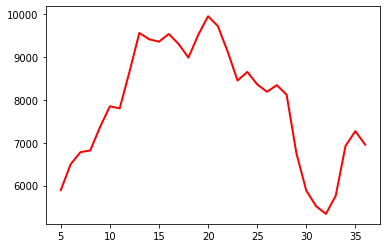

In [32]:
newdf['New York'].diff().rolling(rolling_average_duration).mean().plot()

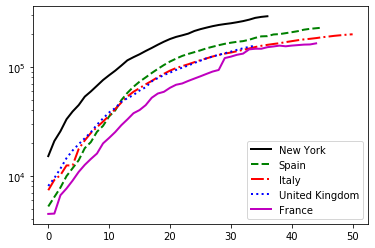

(<matplotlib.axes._subplots.AxesSubplot at 0x128c45bb0>,
 <matplotlib.legend.Legend at 0x125315a90>)

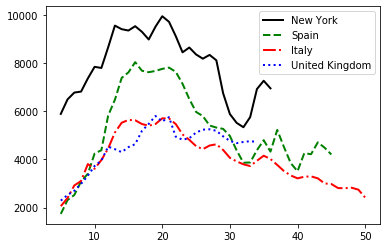

In [33]:
plt.yscale('log')

newdf['New York'].plot(color='k'), newdf_global['Spain'].plot(color='g'), newdf_global['Italy'].plot(),
newdf_global['United Kingdom'].plot(color='b'), newdf_global['France'].plot(color='m'), plt.legend()
plt.show()
daily_us['New York'].plot(color='k'), daily_global['Spain'].plot(color='g'), daily_global['Italy'].plot(),
daily_global['United Kingdom'].plot(color='b'), plt.legend()

['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Switzerland', 'California_deaths', 'California']
['Ohio']
(21, 3400)


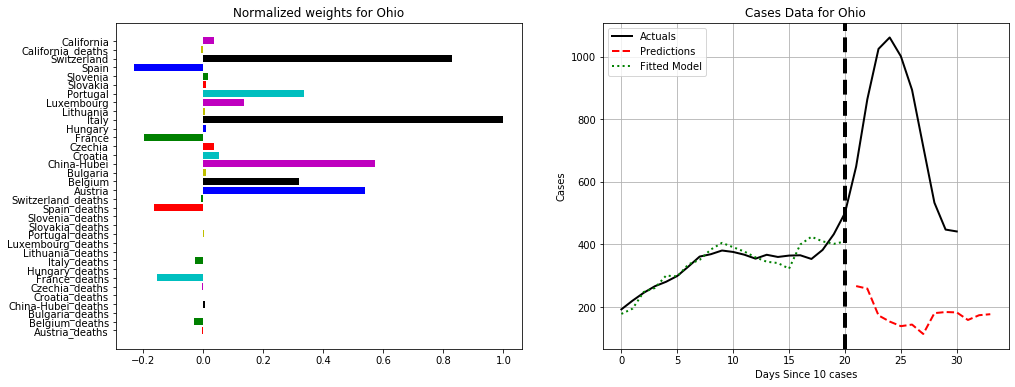

['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Switzerland', 'California_deaths', 'California']
['Ohio minus 7']
(21, 3400)


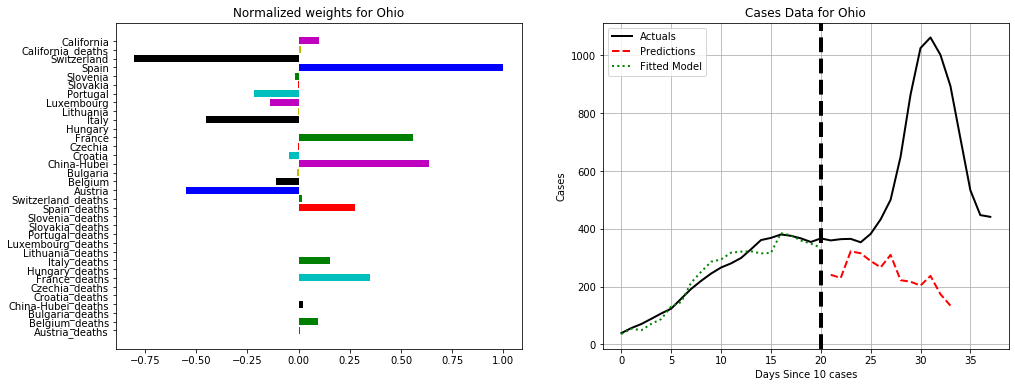

['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Switzerland', 'California_deaths', 'California']
['New York']
(21, 3400)


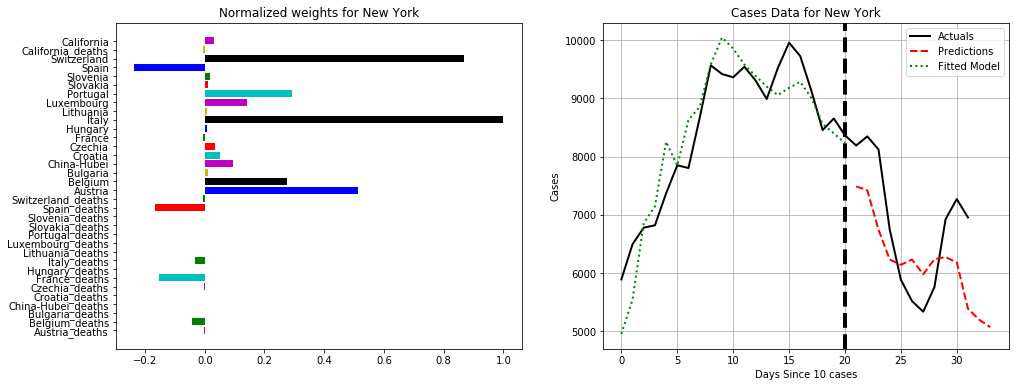

['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Switzerland', 'California_deaths', 'California']
['New York minus 7']
(21, 3400)


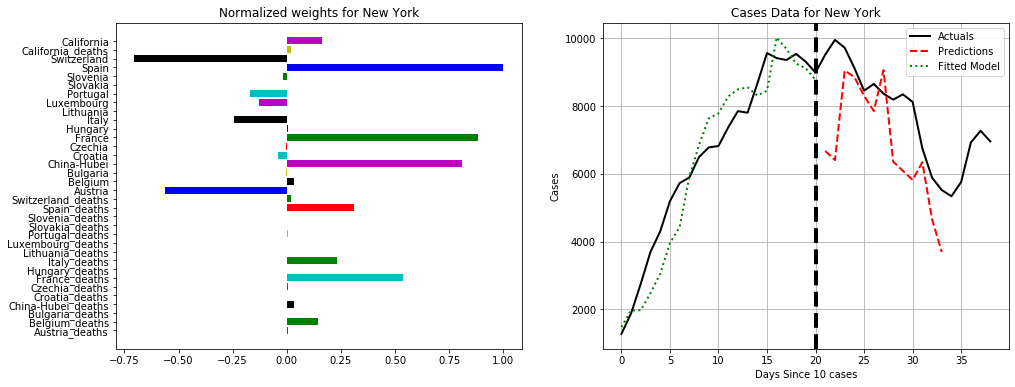

['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Switzerland', 'California_deaths', 'California']
['Illinois']
(21, 3400)


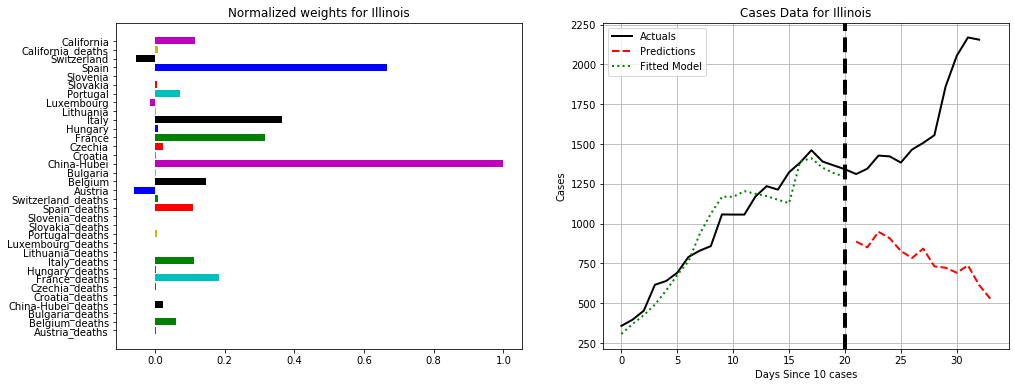

['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Switzerland', 'California_deaths', 'California']
['Illinois minus 7']
(21, 3400)


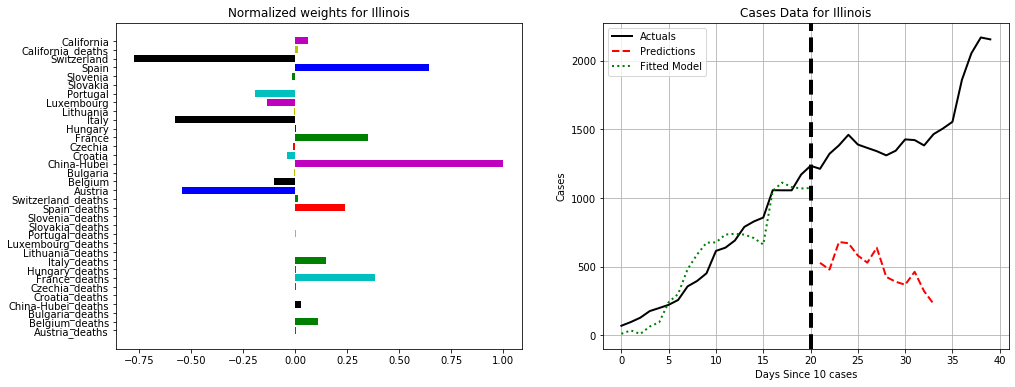

['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Switzerland', 'California_deaths', 'California']
['Belgium']
(21, 3400)


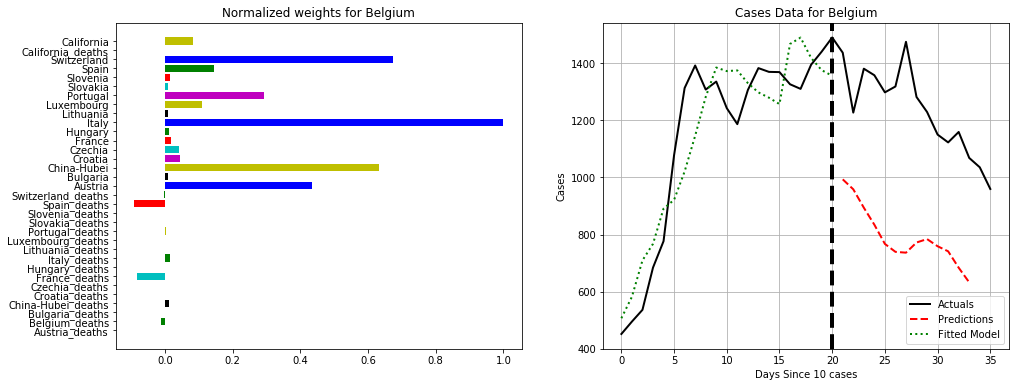

['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Switzerland', 'California_deaths', 'California']
['Belgium minus 7']
(21, 3400)


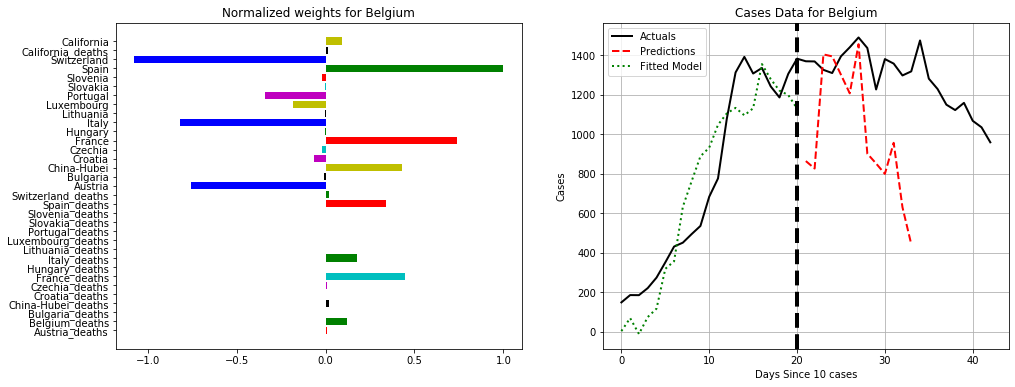

['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'California_deaths', 'California']
['Switzerland']
(21, 3400)


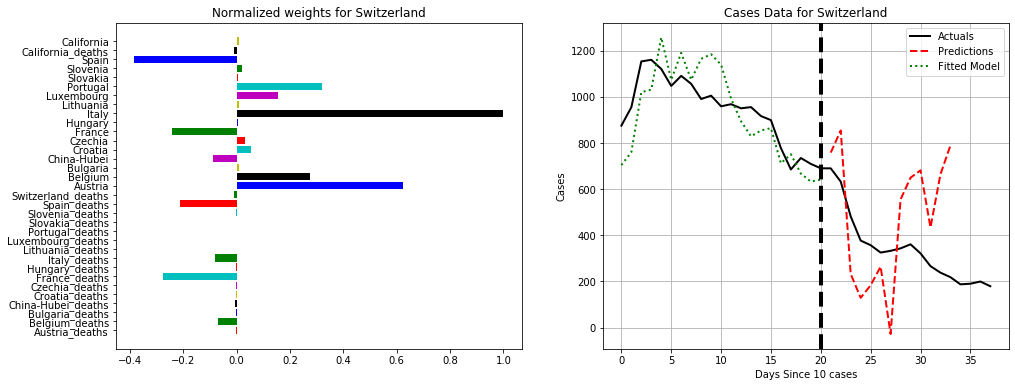

['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'California_deaths', 'California']
['Switzerland minus 7']
(21, 3400)


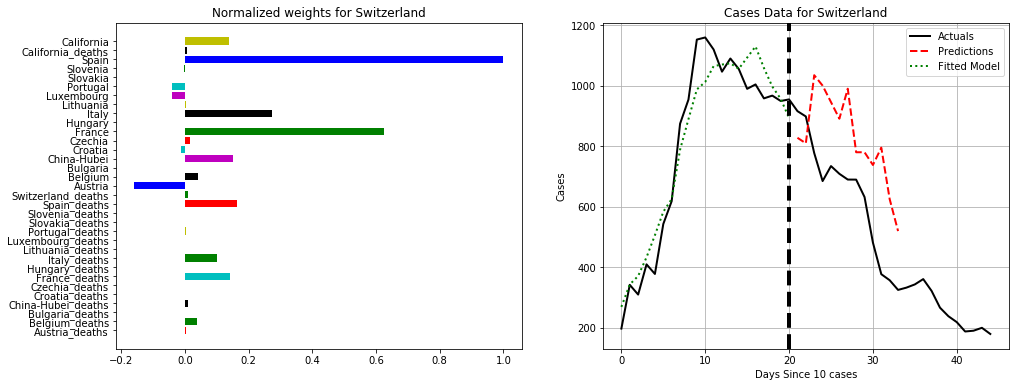

['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Switzerland', 'California_deaths', 'California']
['New Jersey']
(21, 3400)


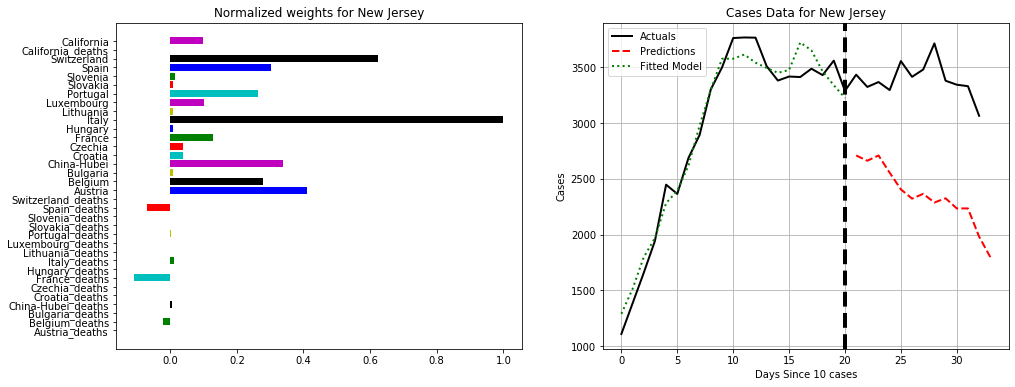

['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Switzerland', 'California_deaths', 'California']
['New Jersey minus 7']
(21, 3400)


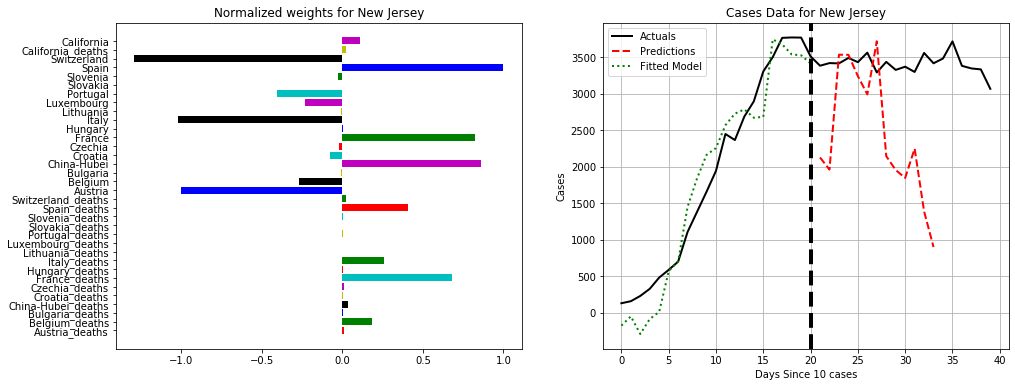

['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Switzerland', 'California_deaths', 'California']
['France']
(21, 3400)


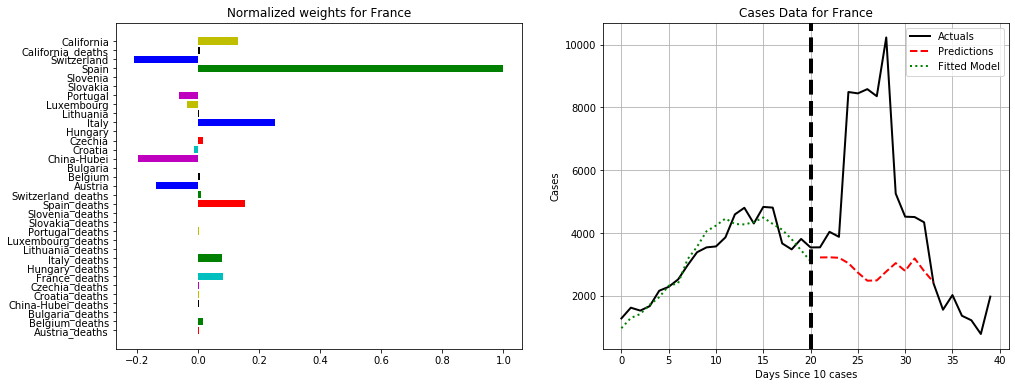

['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Switzerland', 'California_deaths', 'California']
['France minus 7']
(21, 3400)


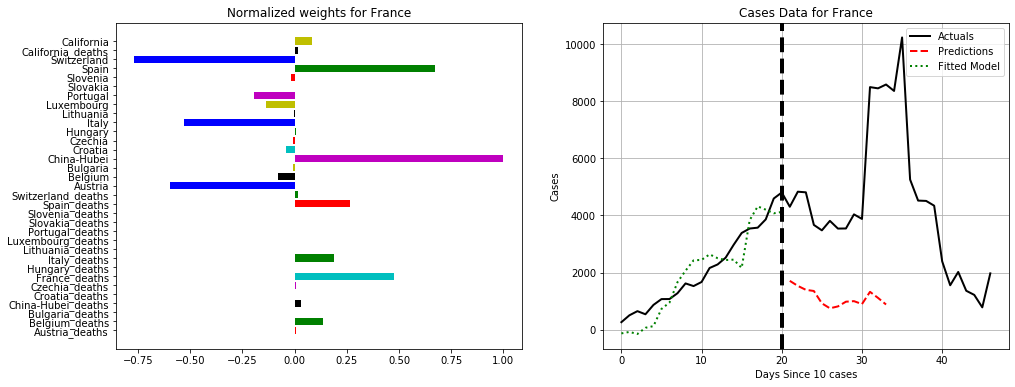

['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Lithuania', 'Luxembourg', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Switzerland', 'California_deaths', 'California']
['Italy']
(21, 3400)


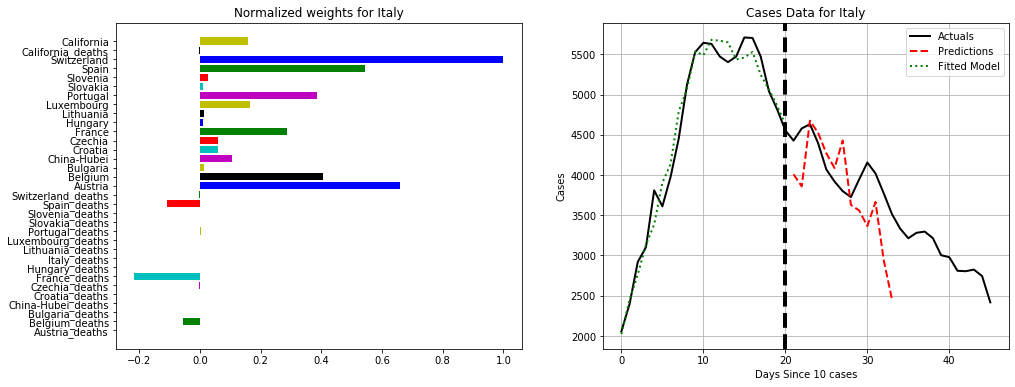

['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Lithuania', 'Luxembourg', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Switzerland', 'California_deaths', 'California']
['Italy minus 7']
(21, 3400)


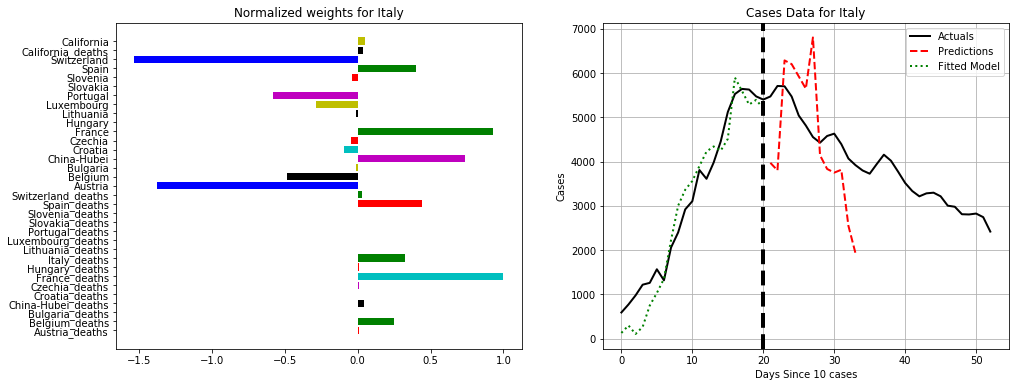

['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Switzerland', 'California_deaths', 'California']
['United Kingdom']
(21, 3400)


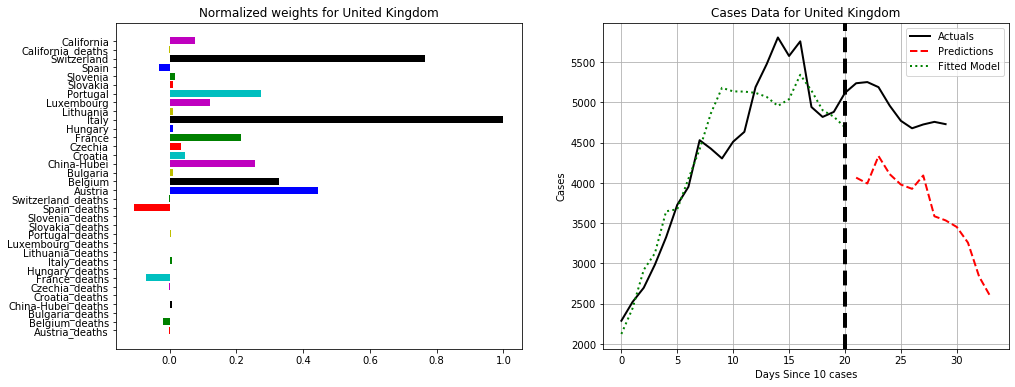

['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Switzerland', 'California_deaths', 'California']
['United Kingdom minus 7']
(21, 3400)


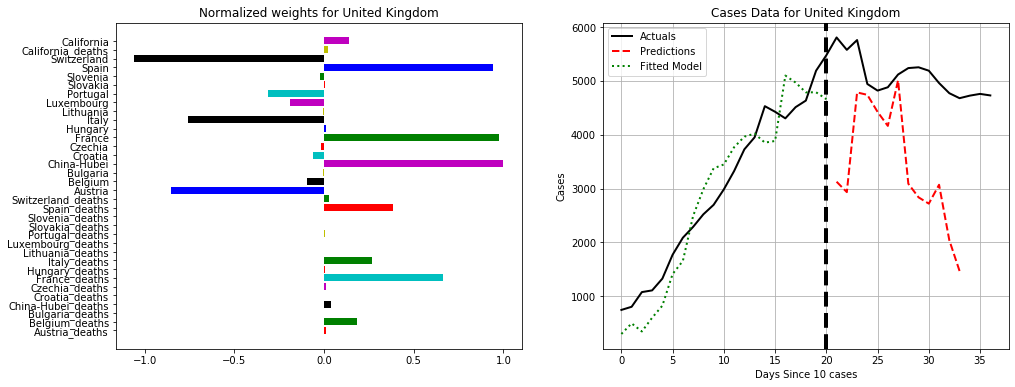

In [34]:
#target = ['New York City-New York', 'Los Angeles-California', 'Wayne-Michigan', 'Miami-Dade-Florida']
#targets =  ['Santa Clara-California', 'Los Angeles-California', 'New York City-New York', 'Cook-Illinois', 'Wayne-Michigan', 'Miami-Dade-Florida', 'Middlesex-Massachusetts']
targets = ['Ohio', 'New York', 'Illinois', 'Belgium', 'Switzerland', 'New Jersey', 'France', 'Italy', 'United Kingdom']# 'Ohio', 'Sweden']
#exclude1 = ['Iraq','China-Anhui', 'China-Beijing', 'China-Chongqing', 'China-Guangdong', 'China-Hainan', 'China-Hebei', 'China-Heilongjiang',  'China-Shandong', 'Diamond Princess']
#exclude2=['Iran', 'Italy','France', 'Spain',  'Germany', 'United Kingdom']
#for i in [0,15]:
trial = pd.concat([daily_global, daily_us], axis=1)
singVals =3
#trial = pd.concat([newdf, newdf_global], axis=1)
    
for target in targets:
    sizes = trial[[target]].apply(pd.Series.last_valid_index)
    #print(sizes)
    length = sizes.loc[target]
    #print(length)
    synth_control_predictions2(trial,38,21, "Cases Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                               exclude=matching+matching_us, svdSpectrum=False)
    
    synth_control_predictions2(trial,38,21, "Cases Data", singVals, ylimit=[], savePlots=False, do_only=[target+" minus 7"], showstates=10,
                               exclude=matching+matching_us+[target])
   


['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Switzerland', 'California_deaths', 'California']
['United Kingdom minus 1']
(21, 3400)
['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal

<ipython-input-2-ef60cc5f845b>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-2-ef60cc5f845b>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)


['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Switzerland', 'California_deaths', 'California']
['United Kingdom minus 3']
(21, 3400)
['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal

<ipython-input-2-ef60cc5f845b>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-2-ef60cc5f845b>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)


['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Switzerland', 'California_deaths', 'California']
['United Kingdom minus 5']
(21, 3400)
['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal

<ipython-input-2-ef60cc5f845b>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-2-ef60cc5f845b>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)


['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Switzerland', 'California_deaths', 'California']
['United Kingdom minus 7']
(21, 3400)
['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal

<ipython-input-2-ef60cc5f845b>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)


['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Switzerland', 'California_deaths', 'California']
['United Kingdom minus 9']
(21, 3400)
['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal

<ipython-input-2-ef60cc5f845b>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-2-ef60cc5f845b>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)


['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Switzerland', 'California_deaths', 'California']
['United Kingdom minus 11']
(21, 3400)
['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portuga

<ipython-input-2-ef60cc5f845b>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-2-ef60cc5f845b>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)


['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Switzerland', 'California_deaths', 'California']
['United Kingdom minus 13']
(21, 3400)
['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portuga

<ipython-input-2-ef60cc5f845b>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-2-ef60cc5f845b>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)


['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Switzerland', 'California_deaths', 'California']
['United Kingdom minus 15']
(21, 3400)
['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portuga

<ipython-input-2-ef60cc5f845b>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-2-ef60cc5f845b>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)


['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Switzerland', 'California_deaths', 'California']
['United Kingdom minus 17']
(21, 3400)
['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portuga

<ipython-input-2-ef60cc5f845b>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-2-ef60cc5f845b>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)


['Austria_deaths', 'Belgium_deaths', 'Bulgaria_deaths', 'China-Hubei_deaths', 'Croatia_deaths', 'Czechia_deaths', 'France_deaths', 'Hungary_deaths', 'Italy_deaths', 'Lithuania_deaths', 'Luxembourg_deaths', 'Portugal_deaths', 'Slovakia_deaths', 'Slovenia_deaths', 'Spain_deaths', 'Switzerland_deaths', 'Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Czechia', 'France', 'Hungary', 'Italy', 'Lithuania', 'Luxembourg', 'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Switzerland', 'California_deaths', 'California']
['United Kingdom minus 19']
(21, 3400)


<ipython-input-2-ef60cc5f845b>:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)


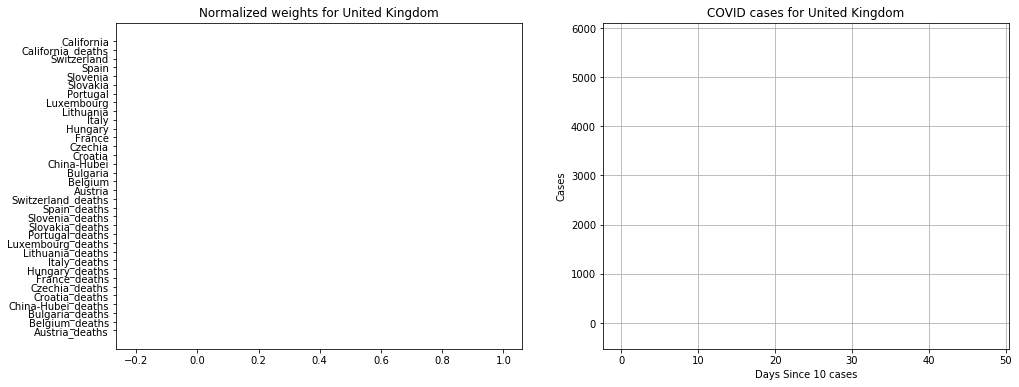

In [35]:
#target = ['New York City-New York', 'Los Angeles-California', 'Wayne-Michigan', 'Miami-Dade-Florida']
targets =  ['United Kingdom']#'Italy', 'France', 'United Kingdom', 'New York', 'Spain', 'Switzerland']#'New Jersey', 'Ohio', 'Florida', 'Michigan', 'California']
#targets = ['Switzerland', 'Belgium']# 'Netherlands']# 'Ohio', 'Sweden']
exclude1 = ['Iran', 'Iraq','China-Anhui', 'China-Beijing', 'China-Chongqing', 'China-Guangdong', 'China-Henan', 'China-Hainan', 'China-Hebei', 'China-Heilongjiang',  'China-Shandong', 'Diamond Princess', 'US']
exclude2=['Iran', 'Italy','France', 'Spain',  'Germany', 'United Kingdom']
#trial = pd.concat([daily_global, daily_uscountines], axis=1)
trial = pd.concat([daily_global, daily_us], axis=1)

#fig = plt.figure(figsize=(16,6))
#camera = Camera(fig)
singVals =2  

   

for target in targets:
    fig = plt.figure(figsize=(16,6))
    camera = Camera(fig)
    for i in range(1,20):
        synth_control_predictions2(trial,38,21, "COVID cases", singVals, ylimit=[], savePlots=False, do_only=[target+" minus %s"%i], showstates=12,
                                   exclude=matching+matching_us, animation=camera)
animation = camera.animate()

HTML(animation.to_html5_video())

    #animation.save('../animations/'+target+" no donors shown"'.mp4')
